Dataset loaded successfully!
Features: (569, 30), Target: (569,)
Priority distribution:
low       357
high      199
medium     13
Name: count, dtype: int64
🎯 FINAL PERFORMANCE METRICS:
Accuracy: 0.9591
F1-Score (weighted): 0.9505

📊 Classification Report:
              precision    recall  f1-score   support

        high       0.98      0.97      0.97        60
         low       0.95      0.99      0.97       107
      medium       0.00      0.00      0.00         4

    accuracy                           0.96       171
   macro avg       0.65      0.65      0.65       171
weighted avg       0.94      0.96      0.95       171



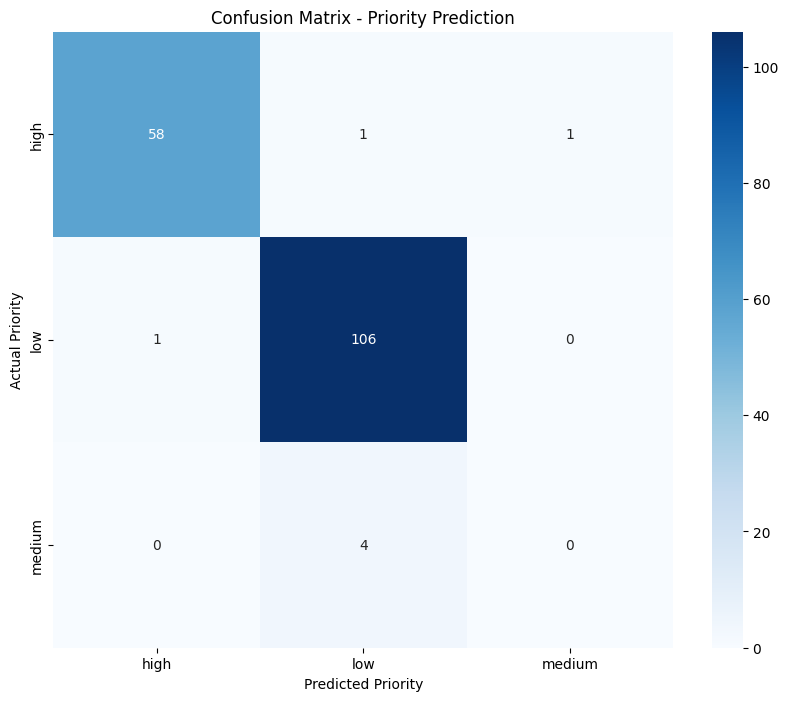

🏥 RESOURCE ALLOCATION SUMMARY:
HIGH PRIORITY: 59 cases predicted
  - Actual: 60 cases
  - Resource allocation needed
LOW PRIORITY: 111 cases predicted
  - Actual: 107 cases
  - Resource allocation needed
MEDIUM PRIORITY: 1 cases predicted
  - Actual: 4 cases
  - Resource allocation needed


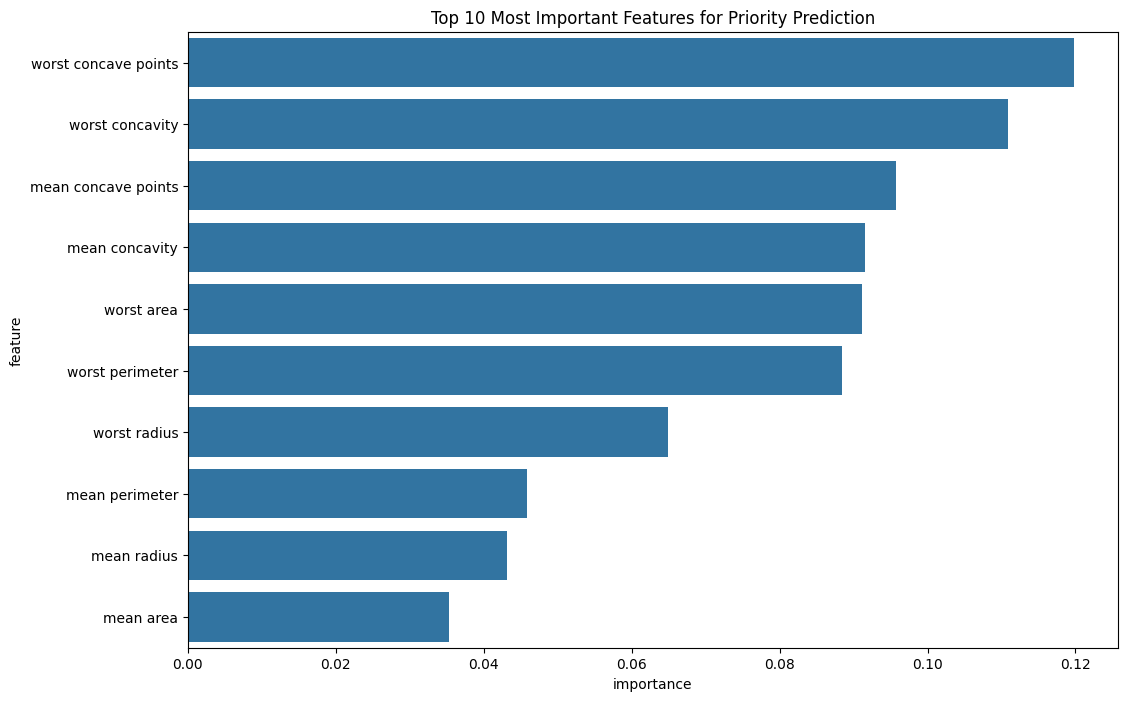

In [1]:
# This would be in Jupyter Notebook cells:

# Cell 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Cell 2: Load data
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

print("Dataset loaded successfully!")
print(f"Features: {X.shape}, Target: {y.shape}")

# Cell 3: Create 3-level priority system
def create_priority_system(X, y):
    """Create High/Medium/Low priority levels"""
    priorities = []
    
    for i in range(len(y)):
        if y.iloc[i] == 1:  # Benign - Low priority
            priorities.append('low')
        else:  # Malignant - determine high/medium
            # Use worst area and worst concavity as risk indicators
            area = X.iloc[i][X.columns.str.contains('worst area')].values[0]
            concavity = X.iloc[i][X.columns.str.contains('worst concavity')].values[0]
            
            if area > 1000 or concavity > 0.3:  # High risk
                priorities.append('high')
            else:  # Medium risk
                priorities.append('medium')
    
    return pd.Series(priorities)

# Create priority labels
y_priority = create_priority_system(X, y)
print("Priority distribution:")
print(y_priority.value_counts())

# Cell 4: Data splitting
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y_priority)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Cell 5: Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    class_weight='balanced'
)

rf_model.fit(X_train_scaled, y_train)

# Cell 6: Evaluate model
y_pred = rf_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print("🎯 FINAL PERFORMANCE METRICS:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score (weighted): {f1:.4f}")

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Cell 7: Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.title('Confusion Matrix - Priority Prediction')
plt.xlabel('Predicted Priority')
plt.ylabel('Actual Priority')
plt.show()

# Cell 8: Resource Allocation Analysis
print("🏥 RESOURCE ALLOCATION SUMMARY:")
priority_mapping = dict(zip(range(len(le.classes_)), le.classes_))
for i in range(len(le.classes_)):
    count = sum(y_pred == i)
    actual_count = sum(y_test == i)
    print(f"{priority_mapping[i].upper()} PRIORITY: {count} cases predicted")
    print(f"  - Actual: {actual_count} cases")
    print(f"  - Resource allocation needed")

# Cell 9: Feature Importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Most Important Features for Priority Prediction')
plt.show()